<a href="https://colab.research.google.com/github/AtakaNKuscu/Physics-Informed-Neural-Networks/blob/main/underdampedsystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

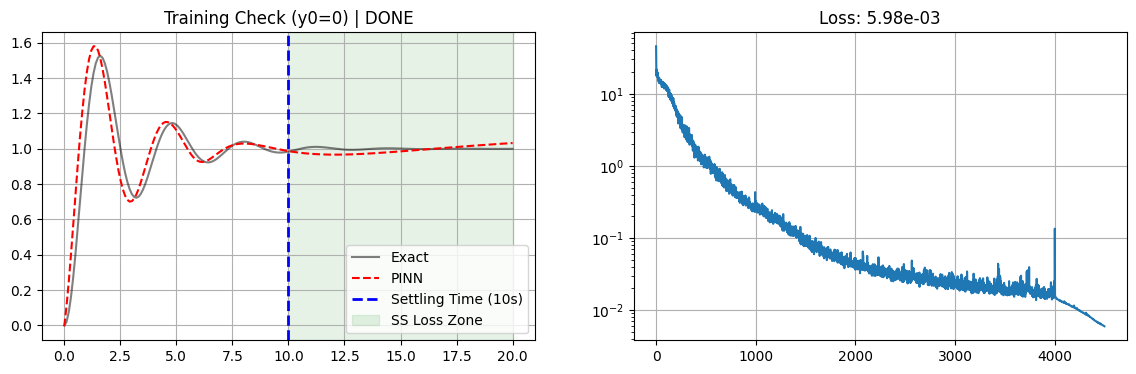


>>> FİNAL TEST RAPORU OLUŞTURULUYOR...
Case 1: Standart (0,0) -> MSE: 6.88e-02
Case 2: Genelleme 1 (-1.5, 2) -> MSE: 4.19e-01
Case 3: Genelleme 2 (2, -3) -> MSE: 1.03e-01


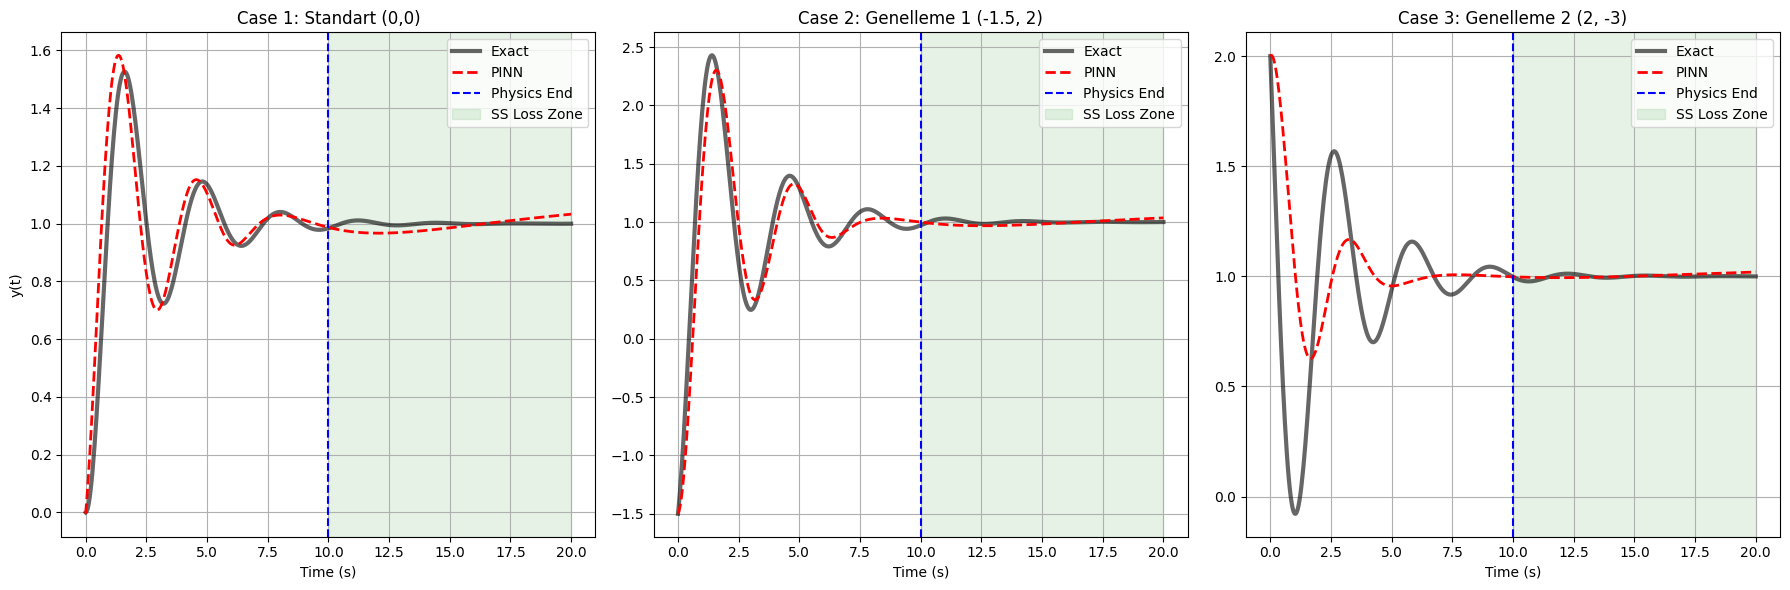

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 1. SİSTEM PARAMETRELERİ VE TEORİK HESAP
# ==========================================
zeta, wn = 0.2, 2.0
a1, a0, rhs = 2*zeta*wn, wn**2, wn**2

# Kontrol Teorisi Hesabı
tau = 1 / (zeta * wn)
settling_time = 4 * tau  # %2 kriterine göre oturma zamanı

print(f"--- SİSTEM BİLGİSİ ---")
print(f"Zaman Sabiti (Tau): {tau:.2f} s")
print(f"Teorik Oturma Süresi (Settling Time): {settling_time:.2f} s")
print(f"Eğitim Stratejisi: 0-{settling_time:.0f}s arası FİZİK, {settling_time:.0f}s-20s arası STEADY STATE.")
print("----------------------")

# Zaman Ayarları
t_train_limit = settling_time # Fizik kuralları buraya kadar (10s)
t_test_max    = 20.0          # Test ve SS Loss buraya kadar

# ==========================================
# 2. MODEL
# ==========================================
class UniversalPINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: t, y0, dy0
        self.net = nn.Sequential(
            nn.Linear(3, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )
    def forward(self, t, y0, dy0):
        # Input Scaling: t'yi 20'ye bölerek normalize et
        inputs = torch.cat([t/20.0, y0, dy0], dim=1)
        return self.net(inputs)

model = UniversalPINN().to(device)

# Analitik Çözüm (Referans)
def true_solution(t_np, y0, dy0):
    wd = wn * np.sqrt(1 - zeta**2)
    C1 = y0 - 1.0
    C2 = (dy0 + C1*zeta*wn) / wd
    return 1.0 + np.exp(-zeta*wn*t_np) * (C1*np.cos(wd*t_np) + C2*np.sin(wd*t_np))

# ==========================================
# 3. EĞİTİM FONKSİYONU
# ==========================================
def train_dynamic_ss():
    loss_history = []

    # Görselleştirme için sabit bir test vakası (Eğitim sırasındaki plot için)
    t_plot_np = np.linspace(0, 20, 200)
    t_plot = torch.tensor(t_plot_np, dtype=torch.float32).view(-1, 1).to(device)
    y0_demo, dy0_demo = 0.0, 0.0 # Standart durum
    y_true_demo = true_solution(t_plot_np, y0_demo, dy0_demo)

    # --- Live Plot Fonksiyonu ---
    def live_plot_train(step, loss_h, optim_name):
        model.eval()
        with torch.no_grad():
            y0_t = torch.full_like(t_plot, y0_demo)
            dy0_t = torch.full_like(t_plot, dy0_demo)
            pred = model(t_plot, y0_t, dy0_t).cpu().numpy()
        model.train()

        clear_output(wait=True)
        fig, axs = plt.subplots(1, 2, figsize=(14, 4))

        # Grafik 1: Tahmin (0-20s)
        axs[0].plot(t_plot_np, y_true_demo, 'k-', alpha=0.5, label="Exact")
        axs[0].plot(t_plot_np, pred, 'r--', label="PINN")
        # Kritik Çizgiler
        axs[0].axvline(x=t_train_limit, color='blue', linestyle='--', linewidth=2, label=f"Settling Time ({t_train_limit:.0f}s)")
        axs[0].axvspan(t_train_limit, t_test_max, color='green', alpha=0.1, label="SS Loss Zone")
        axs[0].set_title(f"Training Check (y0=0) | {optim_name}")
        axs[0].legend(loc="lower right")
        axs[0].grid(True)

        # Grafik 2: Loss
        axs[1].plot(loss_h)
        axs[1].set_yscale('log')
        axs[1].set_title(f"Loss: {loss_h[-1]:.2e}")
        axs[1].grid(True)
        plt.show()

    # ---------------------------------------------------------
    # AŞAMA 1: ADAM (Random Sampling)
    # ---------------------------------------------------------
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_adam, patience=500, factor=0.5)

    print(">>> ADAM Aşaması Başlıyor...")
    for epoch in range(4001):
        optimizer_adam.zero_grad()

        # 1. Physics Loss: Sadece [0, settling_time] arasında
        N_ph = 1000
        t_ph = (torch.rand(N_ph, 1, device=device) * t_train_limit).requires_grad_(True)

        # Random IC (Trivial zorlaması YOK, tamamen rastgele)
        y0_r = (torch.rand(N_ph, 1, device=device)*4.0)-2.0
        dy0_r = (torch.rand(N_ph, 1, device=device)*6.0)-3.0

        y = model(t_ph, y0_r, dy0_r)
        dy = torch.autograd.grad(y, t_ph, torch.ones_like(y), create_graph=True)[0]
        ddy = torch.autograd.grad(dy, t_ph, torch.ones_like(dy), create_graph=True)[0]
        l_phy = torch.mean((ddy + a1*dy + a0*y - rhs)**2)

        # 2. IC Loss (t=0)
        t0 = torch.zeros(200, 1, device=device).requires_grad_(True)
        y0_ic = (torch.rand(200, 1, device=device)*4.0)-2.0
        dy0_ic = (torch.rand(200, 1, device=device)*6.0)-3.0
        l_bc = torch.mean((model(t0, y0_ic, dy0_ic) - y0_ic)**2)

        # 3. SS Loss: [settling_time, 20] ARASINDAKİ BÖLGE
        # Burada fizik çözmüyoruz, sadece 1'e zorluyoruz.
        N_ss = 400
        # t değerlerini 10 ile 20 arasında rastgele seçiyoruz
        t_ss = (torch.rand(N_ss, 1, device=device) * (t_test_max - t_train_limit)) + t_train_limit

        # IC'leri yine rastgele seçiyoruz (hangi şartla başlarsa başlasın 1'e gitmeli)
        y0_ss = (torch.rand(N_ss, 1, device=device)*4.0)-2.0
        dy0_ss = (torch.rand(N_ss, 1, device=device)*6.0)-3.0

        y_ss_pred = model(t_ss, y0_ss, dy0_ss)
        l_ss = torch.mean((y_ss_pred - 1.0)**2)

        # Toplam Loss
        loss = 2.0*l_phy + 10.0*l_bc + 1.0*l_ss

        loss.backward()
        optimizer_adam.step()
        scheduler.step(loss)
        loss_history.append(loss.item())

        if epoch % 500 == 0:
            live_plot_train(epoch, loss_history, f"Adam (Ep:{epoch})")

    # ---------------------------------------------------------
    # AŞAMA 2: L-BFGS (Sabit Batch ile İnce Ayar)
    # ---------------------------------------------------------
    print(">>> L-BFGS Aşaması Başlıyor (Sabit Batch)...")

    # Verileri Sabitle (Stability için şart)
    N_fix = 2000
    t_ph_fix = (torch.rand(N_fix, 1, device=device) * t_train_limit).requires_grad_(True)
    y0_fix = (torch.rand(N_fix, 1, device=device)*4.0)-2.0
    dy0_fix = (torch.rand(N_fix, 1, device=device)*6.0)-3.0

    t0_fix = torch.zeros(300, 1, device=device).requires_grad_(True)
    y0_ic_fix = (torch.rand(300, 1, device=device)*4.0)-2.0
    dy0_ic_fix = (torch.rand(300, 1, device=device)*6.0)-3.0

    # SS Verisini Sabitle (10s - 20s arası)
    t_ss_fix = (torch.rand(500, 1, device=device) * (t_test_max - t_train_limit)) + t_train_limit
    y0_ss_fix = (torch.rand(500, 1, device=device)*4.0)-2.0
    dy0_ss_fix = (torch.rand(500, 1, device=device)*6.0)-3.0

    optimizer_lbfgs = torch.optim.LBFGS(
        model.parameters(), lr=1.0, max_iter=500, max_eval=500,
        history_size=20, tolerance_grad=1e-9, tolerance_change=1e-9,
        line_search_fn="strong_wolfe"
    )

    lbfgs_iter = 0
    def closure():
        nonlocal lbfgs_iter
        optimizer_lbfgs.zero_grad()

        # Physics Loss (0-10s)
        y = model(t_ph_fix, y0_fix, dy0_fix)
        dy = torch.autograd.grad(y, t_ph_fix, torch.ones_like(y), create_graph=True)[0]
        ddy = torch.autograd.grad(dy, t_ph_fix, torch.ones_like(dy), create_graph=True)[0]
        l_phy = torch.mean((ddy + a1*dy + a0*y - rhs)**2)

        # IC Loss (t=0)
        l_bc = torch.mean((model(t0_fix, y0_ic_fix, dy0_ic_fix) - y0_ic_fix)**2)

        # SS Loss (10s-20s) -> 1.0 Hedefi
        l_ss = torch.mean((model(t_ss_fix, y0_ss_fix, dy0_ss_fix) - 1.0)**2)

        loss = 2.0*l_phy + 10.0*l_bc + 1.0*l_ss
        loss.backward()

        loss_history.append(loss.item())
        lbfgs_iter += 1

        if lbfgs_iter % 100 == 0:
            live_plot_train(lbfgs_iter, loss_history, f"L-BFGS (Iter:{lbfgs_iter})")

        return loss

    optimizer_lbfgs.step(closure)

    # Final plot
    live_plot_train(lbfgs_iter, loss_history, "DONE")
    return loss_history

# ==========================================
# 4. TEST SUITE (TRIVIAL HARİÇ FARKLI IC'LER)
# ==========================================
def final_test_report():
    print("\n>>> FİNAL TEST RAPORU OLUŞTURULUYOR...")

    t_test_np = np.linspace(0, 20, 500)
    t_test = torch.tensor(t_test_np, dtype=torch.float32).view(-1, 1).to(device)

    # Test Senaryoları (Trivial YOK)
    test_cases = [
        {"y0": 0.0,  "dy0": 0.0,  "title": "Case 1: Standart (0,0)"},
        {"y0": -1.5, "dy0": 2.0,  "title": "Case 2: Genelleme 1 (-1.5, 2)"},
        {"y0": 2.0,  "dy0": -3.0, "title": "Case 3: Genelleme 2 (2, -3)"}
    ]

    plt.figure(figsize=(18, 6))

    for i, case in enumerate(test_cases):
        y0_v, dy0_v = case["y0"], case["dy0"]

        # Tahmin
        y0_t = torch.full_like(t_test, y0_v)
        dy0_t = torch.full_like(t_test, dy0_v)

        model.eval()
        with torch.no_grad():
            pred = model(t_test, y0_t, dy0_t).cpu().numpy()

        # Gerçek Veri
        true_val = true_solution(t_test_np, y0_v, dy0_v)

        # Plot
        plt.subplot(1, 3, i+1)
        plt.plot(t_test_np, true_val, 'k-', alpha=0.6, label="Exact", linewidth=3)
        plt.plot(t_test_np, pred, 'r--', label="PINN", linewidth=2)

        # Bölgeler
        plt.axvline(x=t_train_limit, color='blue', linestyle='--', label="Physics End")
        plt.axvspan(t_train_limit, t_test_max, color='green', alpha=0.1, label="SS Loss Zone")

        plt.title(f"{case['title']}")
        plt.xlabel("Time (s)")
        if i==0: plt.ylabel("y(t)")
        plt.legend()
        plt.grid(True)

        mse = np.mean((pred - true_val)**2)
        print(f"{case['title']} -> MSE: {mse:.2e}")

    plt.tight_layout()
    plt.show()

# ==========================================
# ÇALIŞTIRMA
# ==========================================
loss_hist = train_dynamic_ss()
final_test_report()